In [1]:
# Google Colab Only
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval
    !export LC_ALL="en_US.UTF-8"
    !export LD_LIBRARY_PATH="/usr/lib64-nvidia"
    !export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
    !ldconfig /usr/lib64-nvidia
except Exception:
    pass

%pip install -q tabulate

/dataeval/.venv/bin/python3: No module named pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import random
from collections.abc import Sequence
from typing import cast

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from maite_datasets.image_classification import MNIST
from tabulate import tabulate
from torch.utils.data import DataLoader, Dataset, Subset

from dataeval.data import Select
from dataeval.data.selections import Limit
from dataeval.workflows import Sufficiency

np.random.seed(0)
np.set_printoptions(formatter={"float": lambda x: f"{x:0.4f}"})
torch.manual_seed(0)
torch.set_float32_matmul_precision("high")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch._dynamo.config.suppress_errors = True

random.seed(0)
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [3]:
# Configure the dataset transforms

transforms = [
    lambda x: x / 255.0,  # scale to [0, 1]
    lambda x: x.astype(np.float32),  # convert to float32
]

# Download the mnist dataset and apply the transforms and subset the data
train_ds = Select(MNIST(root="./data", image_set="train", transforms=transforms), selections=[Limit(2500)])
test_ds = Select(MNIST(root="./data", image_set="test", transforms=transforms), selections=[Limit(500)])

In [4]:
# Define our network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(6400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Compile the model
model = torch.compile(Net().to(device))

# Type cast the model back to Net as torch.compile returns a Unknown
# Nothing internally changes from the cast; we are simply signaling the type
model = cast(Net, model)

In [5]:
def custom_train(model: nn.Module, dataset: Dataset, indices: Sequence[int]):
    # Defined only for this testing scenario
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    epochs = 10

    # Define the dataloader for training
    dataloader = DataLoader(Subset(dataset, indices), batch_size=8)

    for epoch in range(epochs):
        for batch in dataloader:
            # Load data/images to device
            X = torch.Tensor(batch[0]).to(device)
            # Load one-hot encoded targets/labels to device
            y = torch.argmax(torch.asarray(batch[1], dtype=torch.int).to(device), dim=1)
            # Zero out gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(X)
            # Compute loss
            loss = criterion(outputs, y)
            # Back prop
            loss.backward()
            # Update weights/parameters
            optimizer.step()

In [6]:
def custom_eval(model: nn.Module, dataset: Dataset) -> dict[str, float]:
    # Metrics of interest
    metrics = {
        "Accuracy": torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device),
        "AUROC": torchmetrics.AUROC(task="multiclass", num_classes=10).to(device),
        "TPR at 0.5 Fixed FPR": torchmetrics.ROC(task="multiclass", average="macro", num_classes=10).to(device),
    }
    result = {}
    # Set model layers into evaluation mode
    model.eval()
    dataloader = DataLoader(dataset, batch_size=8)
    # Tell PyTorch to not track gradients, greatly speeds up processing
    with torch.no_grad():
        for batch in dataloader:
            # Load data/images to device
            X = torch.Tensor(batch[0]).to(device)
            # Load one-hot encoded targets/labels to device
            y = torch.argmax(torch.asarray(batch[1], dtype=torch.int).to(device), dim=1)
            preds = model(X)
            for metric in metrics.values():
                metric.update(preds, y)
        # Compute ROC curve
        false_positive_rate, true_positive_rate, _ = metrics["TPR at 0.5 Fixed FPR"].compute()
        # determine interval to examine
        desired_rate = 0.5
        closest_desired_index = torch.argmin(torch.abs(false_positive_rate - desired_rate)).item()
        # return corresponding tpr value
        result["TPR at 0.5 Fixed FPR"] = true_positive_rate[closest_desired_index].cpu()
        result["Accuracy"] = metrics["Accuracy"].compute().cpu()
        result["AUROC"] = metrics["AUROC"].compute().cpu()
    return result

In [7]:
# Instantiate sufficiency metric
suff = Sufficiency(
    model=model,  # type: ignore
    train_ds=train_ds,  # type: ignore
    test_ds=test_ds,  # type: ignore
    train_fn=custom_train,
    eval_fn=custom_eval,
    runs=5,
    substeps=10,
)

In [8]:
# Train & test model
output = suff.evaluate()

W0702 22:48:43.473000 183 torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode


In [9]:
# Print out sufficiency output in a table format
formatted = {"Steps": output.steps, **output.averaged_measures}
print(tabulate(formatted, headers=list(formatted), tablefmt="pretty"))

+-------+----------------------+---------------------+--------------------+
| Steps | TPR at 0.5 Fixed FPR |      Accuracy       |       AUROC        |
+-------+----------------------+---------------------+--------------------+
|  25   |  0.785096275806427   | 0.22600000202655793 | 0.7452809929847717 |
|  41   |  0.9053672790527344  | 0.5151999950408935  | 0.8521784663200378 |
|  69   |  0.9683709859848022  | 0.6319999933242798  | 0.9186212301254273 |
|  116  |  0.9749770641326905  | 0.7096000075340271  | 0.9391248464584351 |
|  193  |  0.9881328701972961  | 0.7600000023841857  | 0.9602133989334106 |
|  322  |  0.9956899046897888  | 0.8212000012397767  | 0.9746083378791809 |
|  538  |  0.9975358009338379  | 0.8763999938964844  | 0.9881841897964477 |
|  898  |  0.9987630724906922  | 0.9036000013351441  | 0.9914544463157654 |
| 1498  |  0.9983268022537232  |  0.919599997997284  | 0.9931858301162719 |
| 2500  |  0.999147379398346   | 0.9335999965667725  | 0.9946498990058898 |
+-------+---

In [10]:
# Print out projected output values
projection = output.project([1000, 2500, 5000])
projected = {"Steps": projection.steps, **projection.averaged_measures}
print(tabulate(projected, list(projected), tablefmt="pretty"))

+-------+----------------------+--------------------+--------------------+
| Steps | TPR at 0.5 Fixed FPR |      Accuracy      |       AUROC        |
+-------+----------------------+--------------------+--------------------+
| 1000  |  0.9973931023335796  | 0.899275947947143  | 0.9897571675509419 |
| 2500  |  0.9976868921206561  | 0.9210352639722386 | 0.9927793226435148 |
| 5000  |  0.9977401287168758  | 0.9299847973567945 | 0.9937331116078916 |
+-------+----------------------+--------------------+--------------------+


In [11]:
### TEST ASSERTION CELL ###
for name, values in output.averaged_measures.items():
    assert -0.02 < values[-1] - projection.averaged_measures[name][-2] < 0.02

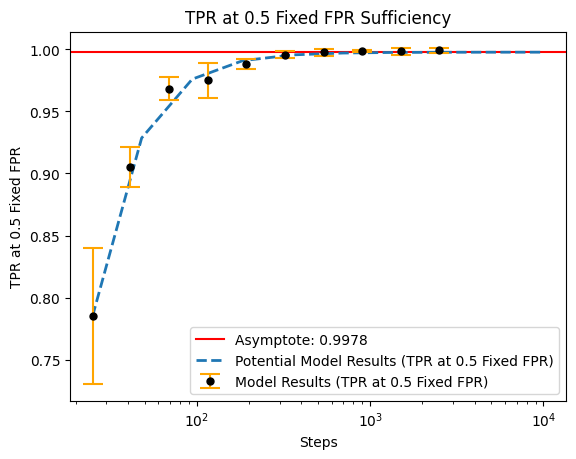

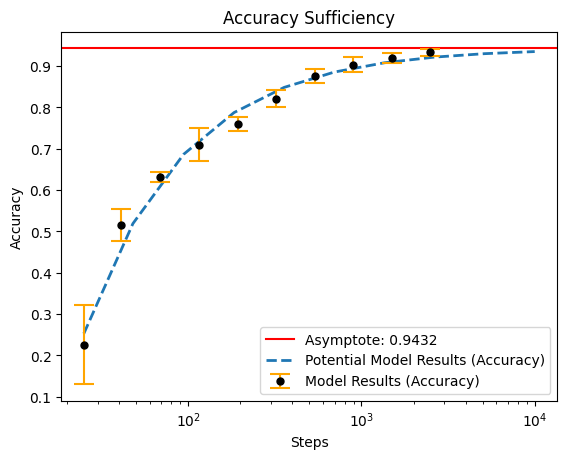

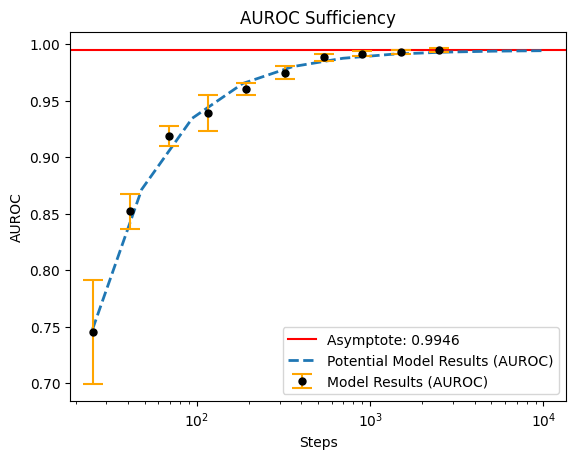

In [12]:
# Plot the output using the convenience function
_ = output.plot(error_bars=True, asymptote=True)

In [13]:
# Initialize the array of desired thresholds to apply to all metrics
desired_values = np.array([0.90, 0.93, 0.99])
metrics = ["Accuracy", "AUROC", "TPR at 0.5 Fixed FPR"]
evaluated_metrics = {}

for metric in metrics:
    evaluated_metrics[metric] = desired_values
# Evaluate the learning curve to infer the needed amount of training data
samples_needed = output.inv_project(evaluated_metrics)

/dataeval/src/dataeval/outputs/_workflows.py:154: UserWarning: Number of samples could not be determined for target(s): [0.99]
  warnings.warn(


In [14]:
# Print the amount of needed data needed to achieve the thresholds
for metric, samples in samples_needed.items():
    print(f"{metric}")
    for index, sample_size in enumerate(samples):
        print(
            f"To achieve {int(evaluated_metrics[metric][index] * 100)}% {metric},"
            f" {int(sample_size)} samples are needed."
        )
    print()

Accuracy
To achieve 90% Accuracy, 1022 samples are needed.
To achieve 93% Accuracy, 5007 samples are needed.
To achieve 99% Accuracy, -1 samples are needed.

AUROC
To achieve 90% AUROC, 61 samples are needed.
To achieve 93% AUROC, 87 samples are needed.
To achieve 99% AUROC, 1049 samples are needed.

TPR at 0.5 Fixed FPR
To achieve 90% TPR at 0.5 Fixed FPR, 39 samples are needed.
To achieve 93% TPR at 0.5 Fixed FPR, 48 samples are needed.
To achieve 99% TPR at 0.5 Fixed FPR, 170 samples are needed.

